In [ ]:
import numpy as np
import pandas as pd
from statsmodels.formula.api import wls
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

### Functions

In [ ]:
def preprocess_profiles(profiles):
    profiles['Saved'] = profiles['Saved'].astype(float)
    profiles['ScenarioType'] = profiles['ScenarioType'].astype('category')
    profiles['AttributeLevel'] = pd.Categorical(profiles['AttributeLevel'], categories=["Rand", "Male", "Female", "Fat", "Fit", "Low", "High", "Old", "Young", "Less", "More", "Pets", "Hoomans"], ordered=True)
    profiles['Barrier'] = pd.Categorical(profiles['Barrier'], categories=[1, 0], ordered=True)
    profiles['CrossingSignal'] = pd.Categorical(profiles['CrossingSignal'], categories=[0, 2, 1], ordered=True)
    profiles['ScenarioType'] = profiles['ScenarioType'].astype('category')
    profiles['ScenarioTypeStrict'] = profiles['ScenarioTypeStrict'].astype('category')
    return profiles

In [ ]:
def calc_weights_actual(Tr, X):
    T10 = np.where(Tr == np.unique(Tr)[1], 1, 0)
    d = np.array([len(X[X == x_i]) for x_i in np.unique(X)])
    w = np.max(d) / d3N
    return w

In [ ]:
def calcWeightsTheoretical(profiles):
    # print(profiles)
    # p = np.apply_along_axis(CalcTheoreticalInt, axis=1, arr=profiles)
    p = profiles.apply(CalcTheoreticalInt, axis=1)
    return 1/p

def CalcTheoreticalInt(X):
    # print(X)
    # print(type(X))
    if X["Intervention"] == 0:
        if X["Barrier"] == 0:
            if X["PedPed"] == 1:
                p = 0.48
            else:
                p = 0.32

            if X["CrossingSignal"] == 0:
                p *= 0.48
            elif X["CrossingSignal"] == 1:
                p *= 0.2
            else:
                p *= 0.32
        else:
            p = 0.2
    else:
        if X["Barrier"] == 0:
            if X["PedPed"] == 1:
                p = 0.48
                if X["CrossingSignal"] == 0:
                    p *= 0.48
                elif X["CrossingSignal"] == 1:
                    p *= 0.32
                else:
                    p *= 0.2
            else:
                p = 0.2
                if X["CrossingSignal"] == 0:
                    p *= 0.48
                elif X["CrossingSignal"] == 1:
                    p *= 0.2
                else:
                    p *= 0.32
        else:
            p = 0.32
    return p

In [ ]:
def GetMainEffectSizes(profiles, savedata, r):
    Coeffs = np.full((r, 2), np.nan)
    AttLevels = list(profiles['AttributeLevel'].unique().categories)
    lev = profiles['ScenarioType'].unique()
    if lev[0] == "":
        lev = lev[1:8]
    lev = ["Gender", "Fitness", "Social Value", "Age", "Utilitarian", "Species"]

    # For intervention
    profiles['BC.weights'] = calcWeightsTheoretical(profiles)
    lm_Int = wls('Saved ~ C(Intervention)', data=profiles, weights=profiles['BC.weights']).fit()
    Coeffs[0, 0] = lm_Int.params.iloc[1]
    Coeffs[0, 1] = lm_Int.bse.iloc[1]
    # print(f"{lm_Int.rsquared=}")

    # # For relationship to vehicle
    profile_Relation = profiles[(profiles['CrossingSignal'] == 0) & (profiles['PedPed'] == 0)].copy()
    profile_Relation['BC.weights'] = calcWeightsTheoretical(profile_Relation)
    lm_Rel = wls('Saved ~ C(Barrier)', data=profile_Relation, weights=profile_Relation['BC.weights']).fit()
    Coeffs[1, 0] = lm_Rel.params.iloc[1]
    Coeffs[1, 1] = lm_Rel.bse.iloc[1]
    # print(f"{lm_Rel.rsquared=}")

    # # Legality
    profile_Legality = profiles[(profiles['CrossingSignal'] != 0) & (profiles['PedPed'] == 1)].copy()
    profile_Legality['CrossingSignal'] = profile_Legality['CrossingSignal'].astype(CategoricalDtype(categories=[1, 2]))#list(profile_Legality['CrossingSignal'].unique())))
    profile_Legality['BC.weights'] = calcWeightsTheoretical(profile_Legality)
    lm_Leg = wls('Saved ~ C(CrossingSignal)', data=profile_Legality, weights=profile_Legality['BC.weights']).fit()
    Coeffs[2, 0] = lm_Leg.params.iloc[1]
    Coeffs[2, 1] = lm_Leg.bse.iloc[1]
    # print(f"{lm_Leg.rsquared=}")

    # Six factors
    for i in range(6):
        Temp = profiles[(profiles['ScenarioType'] == lev[i]) & (profiles['ScenarioTypeStrict'] == lev[i])].copy()
        # Temp['AttributeLevel'] = Temp['AttributeLevel'].astype('category', categories=AttLevels[(i*2):(i*2+1)])

        Temp['AttributeLevel'] = Temp['AttributeLevel'].astype(CategoricalDtype(categories=list(AttLevels[(1+i*2):(1+(i+1)*2)])))
        Temp['BC.weights'] = calcWeightsTheoretical(Temp)
        lm_Temp = wls('Saved ~ C(AttributeLevel)', data=Temp, weights=Temp['BC.weights']).fit()
        Coeffs[i+3, 0] = lm_Temp.params.iloc[1]
        Coeffs[i+3, 1] = lm_Temp.bse.iloc[1]

    #     if savedata:
    #         var_name = f"profile.{lev[i].replace(' ', '')}"
    #         exec(f"{var_name} = Temp")

    return Coeffs

In [ ]:
def GetPlotData(Coeffs, isMainFig, r):
    # Convert to dataframe and add labels
    plotdata = pd.DataFrame(Coeffs, columns=["Estimates", "se"])
    plotdata["Label"] = [
        "Preference for action -> \n Preference for inaction",
        "Sparing Passengers -> \n Sparing Pedestrians",
        "Sparing the Unlawful -> \n Sparing the Lawful",
        "Sparing Males -> \n Sparing Females",
        "Sparing the Large -> \n Sparing the Fit",
        "Sparing Lower Status -> \n Sparing Higher Status",
        "Sparing the Elderly -> \n Sparing the Young",
        "Sparing Fewer Characters -> \n Sparing More Characters",
        "Sparing Pets -> \n Sparing Humans"
    ]

    if isMainFig:
        plotdata["Label"] = [
            "Intervention",
            "Relation to AV",
            "Law",
            "Gender",
            "Fitness",
            "Social Status",
            "Age",
            "No. Characters",
            "Species"
        ]

    sorted_labels = plotdata["Label"].iloc[:r][plotdata["Estimates"].iloc[:r].argsort()].tolist()

    plotdata["Label"] = pd.Categorical(plotdata["Label"], categories=sorted_labels, ordered=True)
    plotdata["Label"] = plotdata["Label"].cat.reorder_categories(sorted_labels[::-1], ordered=True)

    plotdata["Estimates"] = pd.to_numeric(plotdata["Estimates"], errors='coerce')
    plotdata["se"] = pd.to_numeric(plotdata["se"], errors='coerce')

    return plotdata

In [ ]:
def GetMainEffectSizes_Util(profiles):
    Coeffs = np.full((4, 2), np.nan)
    AttLevels = list(profiles['AttributeLevel'].astype('category').cat.categories)
    for i in range(1, 5):
        Temp = profiles[(profiles['ScenarioType'] == "Utilitarian") &
                        (profiles['ScenarioTypeStrict'] == "Utilitarian") &
                        (profiles['DiffNumberOFCharacters'] == i)].copy()
        Temp['AttributeLevel'] = pd.Categorical(Temp['AttributeLevel'], categories=AttLevels[9:11])
        Temp['BC_weights'] = calcWeightsTheoretical(Temp)
        if len(Temp):
          model = wls('Saved ~ C(AttributeLevel)', data=Temp, weights=Temp['BC.weights']).fit()
          Coeffs[i-1, 0] = model.params.iloc[1]
          Coeffs[i-1, 1] = model.bse.iloc[1]
        else:
          Coeffs[i-1, 0] = 0
          Coeffs[i-1, 1] = 0
    return Coeffs



In [ ]:
def GetPlotData_Util(Coeffs):
    plotdata = pd.DataFrame(Coeffs, columns=["Estimates", "se"])
    plotdata['Variant'] = pd.Categorical(range(1, 5), ordered=True)
    plotdata['Label'] = pd.Categorical(["No. Characters"] * 4)
    return plotdata

In [ ]:
def PlotAndSave(plotdata_main, isMainFig, filename, plotdata_util, title=None):
    plotdata_main_human = pd.DataFrame({
        'Estimates': ESTIMATES,
        'Label': LABELS
    })

    plotdata_bars = plotdata_main[plotdata_main['Label'] != "No. Characters"].copy()
    plotdata_points = plotdata_main[plotdata_main['Label'] == "No. Characters"].copy()
    plt.figure(figsize=(9, 6))
    sns.barplot(data=plotdata_bars, x='Estimates', y='Label', color='gray', edgecolor='black', order=plotdata_bars['Label'])
    plt.errorbar(plotdata_bars['Estimates'], plotdata_bars['Label'],
                 xerr=plotdata_bars['se'], fmt='none', c='black', capsize=2)

    max_util = plotdata_util.loc[plotdata_util['Estimates'].abs().idxmax()]
    sns.barplot(data=plotdata_util[plotdata_util['Estimates'] == max_util['Estimates']],
                x='Estimates', y='Label', color='gray', edgecolor='black')
    plt.errorbar(plotdata_points['Estimates'], plotdata_points['Label'],
                 xerr=plotdata_points['se'], fmt='none', c='black', capsize=2)
    # plt.scatter(plotdata_points['Estimates'], plotdata_points['Label'], color='black', s=200)
    # plt.errorbar(plotdata_util['Estimates'], plotdata_util['Label'],
    #              xerr=plotdata_util['se'], fmt='none', c='black', capsize=2)
    # plt.scatter(plotdata_util['Estimates'], plotdata_util['Label'], color='black', s=200, facecolors='white')
    # for i, row in plotdata_util.iterrows():
    #     plt.text(row['Estimates'], row['Label'], str(row['Variant']),
    #              ha='center', va='center', color='black', size=10)

    plt.axvline(x=0, color='black', linewidth=0.4)
    plt.scatter(plotdata_main_human['Estimates'], plotdata_main_human['Label'], color='red', s=100, marker='|')
    plt.xlim(-1.2, 1.2)
    plt.xlabel("\nΔP")
    plt.yticks(rotation=45)
    plt.ylabel("")
    plt.gca().invert_yaxis()

    annotations = {
        "Intervention": ("Action", "Inaction"),
        "Relation to AV": ("Passengers", "Pedestrians"),
        "Law": ("Unlawful", "Lawful"),
        "Gender": ("Males", "Females"),
        "Fitness": ("Large", "Fit"),
        "Social Status": ("Low status", "High status"),
        "Age": ("Old", "Young"),
        "No. Characters": ("Few", "More"),
        "Species": ("Pets", "Humans")
    }

    for label, (left, right) in annotations.items():
        plt.annotate(left, xy=(-1.18, label), ha='left', va='center', color='black', size=12)
        plt.annotate(right, xy=(1.18, label), ha='right', va='center', color='black', size=12)

    plt.tight_layout()
    # plt.savefig(f"{filename}.png")
    if title:
      plt.title(title)
      plt.savefig(f"{title}.svg", format="svg")
    plt.show()

### Dynamics plot

6500
lm_Int.rsquared=0.0003642064709455939
lm_Rel.rsquared=0.007404924984827921
lm_Leg.rsquared=0.0001241396185385213
13000
lm_Int.rsquared=0.00011804282789684706
lm_Rel.rsquared=0.008423201898165367
lm_Leg.rsquared=4.1677068575385334e-05
19500
lm_Int.rsquared=7.361462929733609e-05
lm_Rel.rsquared=0.011066528531507136
lm_Leg.rsquared=4.631747497829686e-05
26000
lm_Int.rsquared=9.952903580323635e-05
lm_Rel.rsquared=0.01191714002917832
lm_Leg.rsquared=0.00017459276183939831
32500
lm_Int.rsquared=9.398908605584566e-05
lm_Rel.rsquared=0.011048197140479887
lm_Leg.rsquared=0.00013543457079412402
39000
lm_Int.rsquared=0.00012719949701345268
lm_Rel.rsquared=0.01206228957212474
lm_Leg.rsquared=6.932622438959868e-05
45500
lm_Int.rsquared=0.00011384519456791864
lm_Rel.rsquared=0.011652466276583229
lm_Leg.rsquared=0.00011113604433066193
49991
lm_Int.rsquared=8.993993899253372e-05
lm_Rel.rsquared=0.010760388935604603
lm_Leg.rsquared=0.0003203430434880472
 Llama 3 Uncensored Rus
6500
lm_Int.rsquared

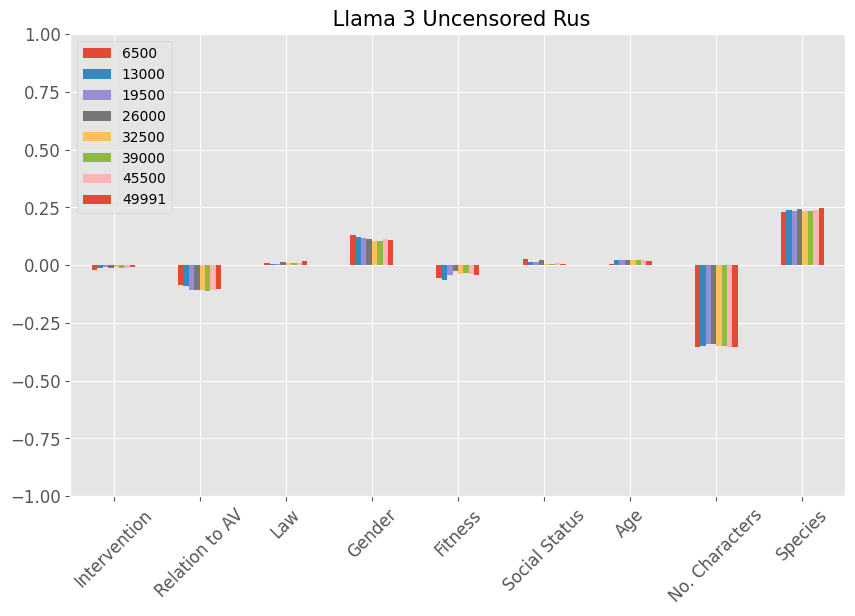

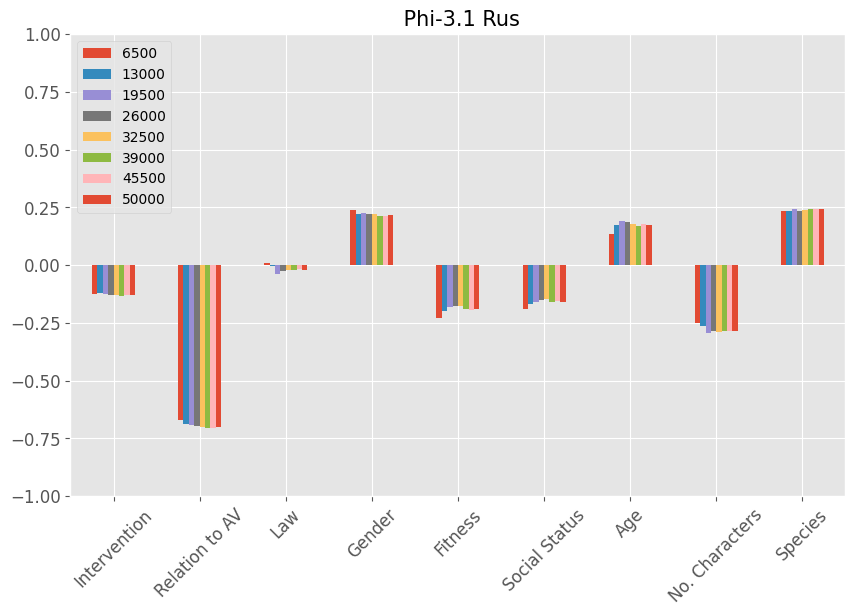

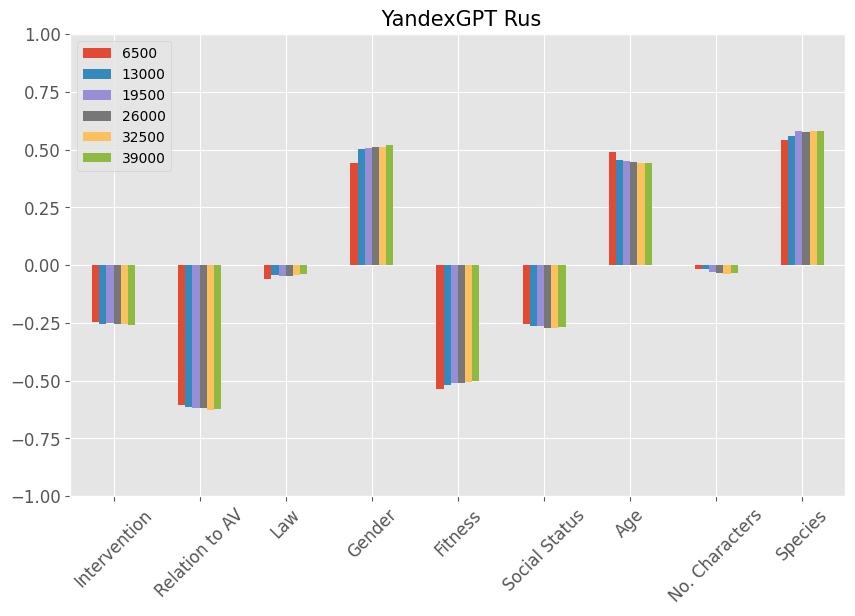

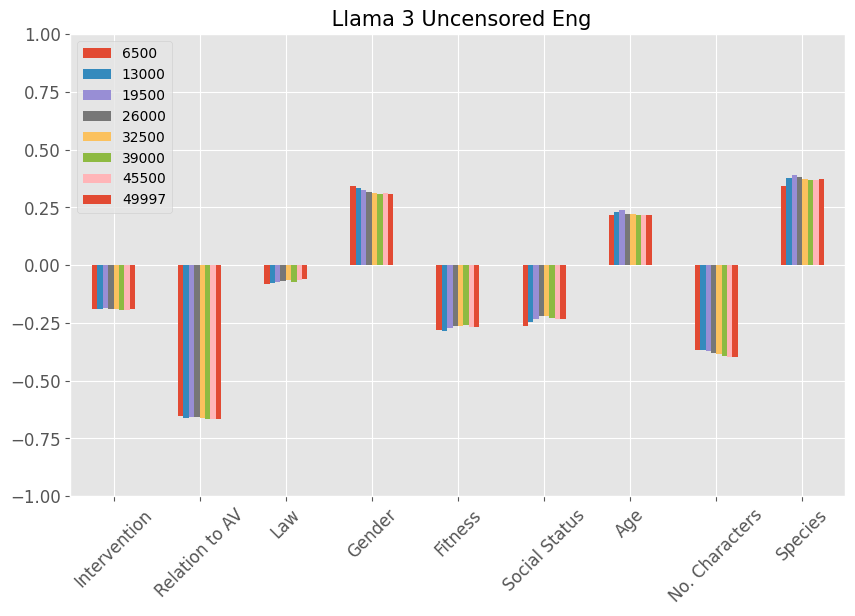

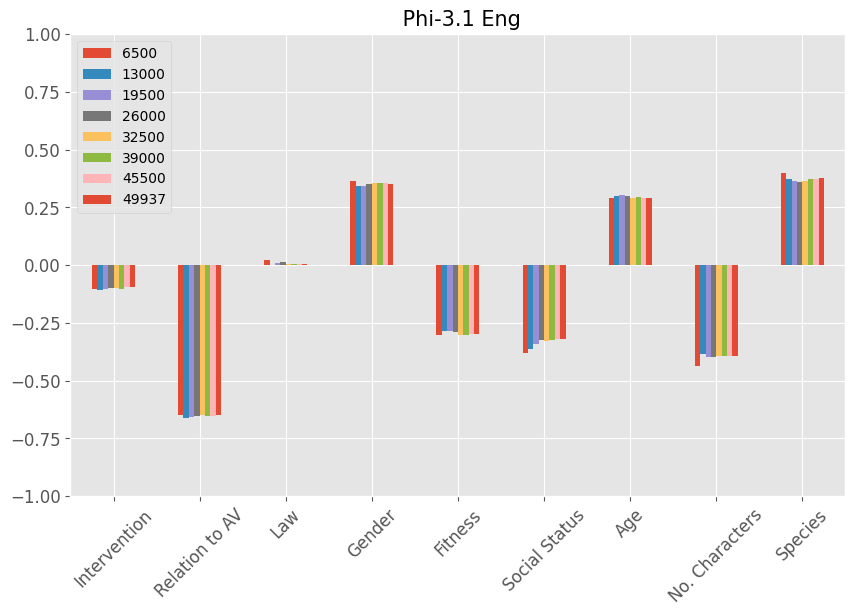

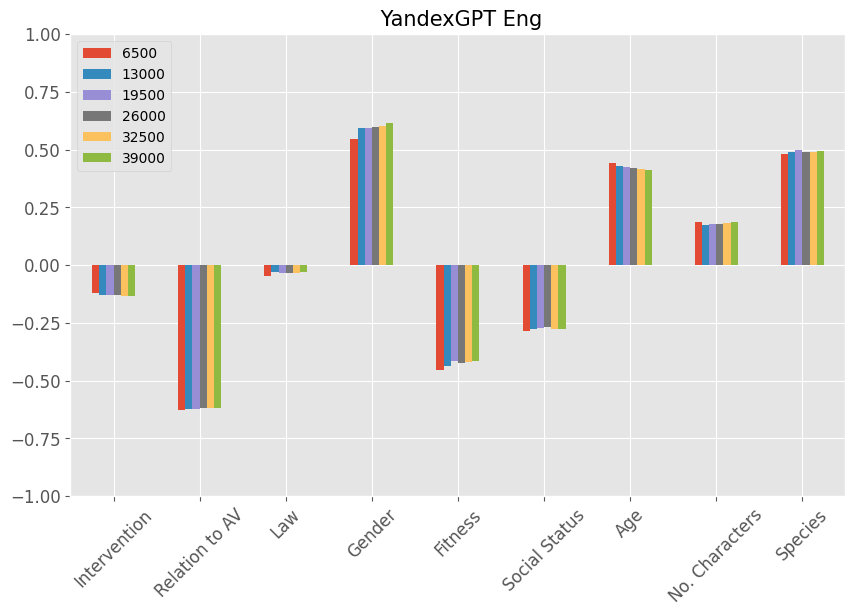

In [ ]:
for profile_names, title, iters in [
    # ("eng_yagpt_responses_40k.csv", "YandexGPT Eng", 7),
    # ("yagpt_responses_40k.csv", "YandexGPT Rus", 7),
    # ("eng_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "Phi-3.1 Eng", 9),
    # ("response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "Phi-3.1 Rus", 9),
    # ("fr_results_yandex_gpt_10k.csv", "YandexGPT Fr", 6),
    # ("eng_words_for_digits_results_yandex_gpt_15000.csv", "YandexGPT Word for Digit Eng", 8),
    # ("rus_words_for_digits_results_yandex_gpt_15000.csv", "YandexGPT Word for Digit Rus", 8),
    ("rus_response_OrengutengLlama_3_8B_Lexi_Uncensored_GGUFLexi_Llama.csv", "Llama 3 Uncensored Rus", 9),
    ("rus_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "Phi-3.1 Rus", 9),
    ("rus_yagpt_responses_40k.csv", "YandexGPT Rus", 7),
    # ("rus_words_for_digits_results_yandex_gpt_15000", "YandexGPT Words for Digits Rus", 4)
    ("eng_response_OrengutengLlama_3_8B_Lexi_Uncensored_GGUFLexi_Llama.csv", "Llama 3 Uncensored Eng", 9),
    ("eng_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "Phi-3.1 Eng", 9),
    ("eng_yagpt_responses_40k.csv", "YandexGPT Eng", 7)
]:
  plt.style.use('ggplot')
  profiles = pd.read_csv(profile_names)
  profiles = preprocess_profiles(profiles)
  for var in [""]:#["", "Random"]:
      data_dict = {}
      for i, k in enumerate([min(6500*i, len(profiles)//2) for i in range(1, iters)]):
      # for k in [1024, 2048, 4096, 8192, 16384, 32778, min(50000, len(profiles)//2)]:
        print(k)
        if var=="Random":
          part_profiles = profiles.sample(2*k)#
        else:
          part_profiles = profiles[profiles.index < 2*k].copy() #profiles.sample(k)#

        Coeffs_main = GetMainEffectSizes(part_profiles, True, 9)
        plotdata_main = GetPlotData(Coeffs_main, True, 9)

        data_dict[f"{k}"] = list(plotdata_main["Estimates"])

      labels = list(plotdata_main["Label"])

      df = pd.DataFrame(data_dict, index=labels)
      cur_title = var+" "+title

      print(cur_title)
      latex_code = df.to_latex(
          index=True,
          header=True,
          column_format="|c|" + "c|" * len(df.columns),
          caption="Table Type Styles",
          label="tab1",
          float_format="{:.3f}".format
      )

      latex_code = latex_code.replace("\\toprule", "\\hline").replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
      latex_code = latex_code.replace("\\\\\n", "\\\\ \\hline\n")
      # print(latex_code)
      df.plot.bar(rot=45, figsize=(10,6), ylim=(-1, 1), fontsize=12).legend(loc='upper left', fontsize=10)
      plt.title(cur_title, fontsize=15)
      plt.savefig(f"{cur_title}.svg", format="svg")


### Single plot

In [ ]:
profiles = pd.read_csv("ru_swapped_results_yandex_gpt_10000.csv")
profiles = preprocess_profiles(profiles)

In [ ]:
estimates_dict = {
    "eng": [0.061, 0.097, 0.353, 0.119, 0.160, 0.345, 0.497, 0.651, 0.585],
    "rus": [0.068, 0.045, 0.385, 0.037, 0.156, 0.340, 0.449, 0.455, 0.606],
    "de": [0.0838269942588847,	0.127411138195979,	0.358406251354378,	0.0947366459175592,	0.14244207016663,	0.294729624780804,	0.478149581129544,	0.502871504134362,	0.648889960937345,],
    "fr": [0.0420471220635806,	0.0935311933482229,	0.375625438531484,	0.217038568155611,	0.156287594695824,	0.372217503675617,	0.585255004630747,	0.556109558152752,	0.642259611687468,]
}

ESTIMATES = estimates_dict["rus"]
LABELS = ["Intervention", "Relation to AV", "Law", "Gender", "Fitness", "Social Status", "Age", "No. Characters", "Species"]

In [ ]:
Coeffs_main = GetMainEffectSizes(profiles, True, 9)
plotdata_main = GetPlotData(Coeffs_main, True, 9)
plotdata_main

lm_Int.rsquared=0.009021026585005809
lm_Rel.rsquared=0.35291165350374987
lm_Leg.rsquared=0.031690006886955446


,Estimates,se,Label
0,-0.093843,0.006957,Intervention
1,0.593865,0.009312,Relation to AV
2,-0.178017,0.013886,Law
3,0.348114,0.015687,Gender
4,-0.298482,0.015943,Fitness
5,0.164681,0.017424,Social Status
6,0.200145,0.016474,Age
7,0.177919,0.016937,No. Characters
8,0.753995,0.011117,Species


In [ ]:
latex_code = plotdata_main.set_index("Label").to_latex(
    index=True,
    header=True,
    column_format="|c|" + "c|" * len(df.columns),
    caption="Table Type Styles",
    label="tab1",
    float_format="{:.3f}".format
)

latex_code = latex_code.replace("\\toprule", "\\hline").replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
latex_code = latex_code.replace("\\\\\n", "\\\\ \\hline\n")
# latex_code += "\\multicolumn{4}{l}{$^{\\mathrm{a}}$Sample of a Table footnote.}\n"
print(latex_code)


In [ ]:
Coeffs_util = GetMainEffectSizes_Util(profiles)
plotdata_util = GetPlotData_Util(Coeffs_util)

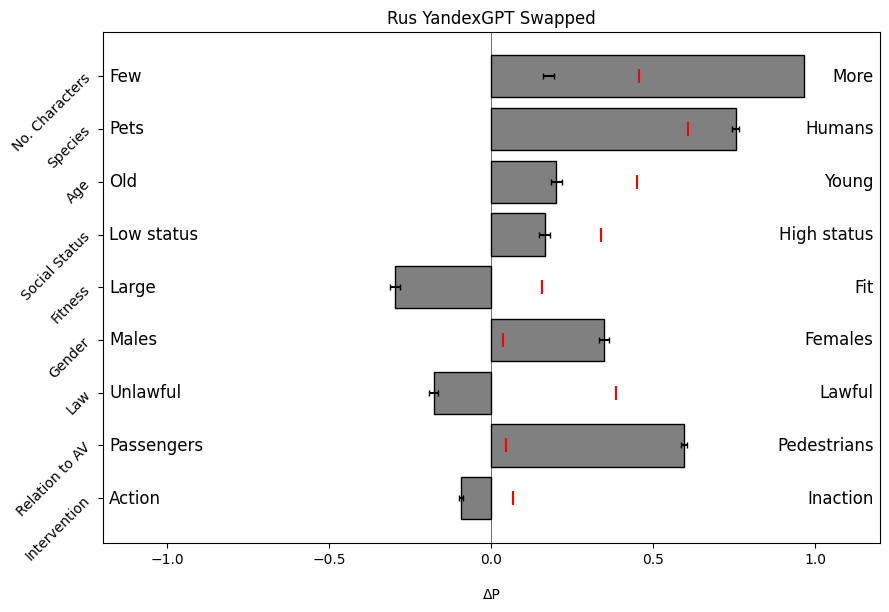

In [ ]:
PlotAndSave(plotdata_main, True, "MainChangePr", plotdata_util, title="Rus YandexGPT Swapped")

### Difference plot

In [ ]:
file_ru = "yagpt_responses_40k.csv"
file_en = "eng_yagpt_responses_40k.csv"
file_fr = "fr_results_yandex_gpt_10k.csv"
file_ge = "ge_results_yandex_gpt_10000.csv"

In [ ]:
lang1 = "eng"
lang2 = "eng"

file1 = "rus_yagpt_responses_40k.csv"
file2 = "rus_words_for_digits_results_yandex_gpt_15000.csv"

In [ ]:
profiles = pd.read_csv(file1)
profiles = preprocess_profiles(profiles)
Coeffs_main = GetMainEffectSizes(profiles, True, 9)
plotdata_main1 = GetPlotData(Coeffs_main, True, 9)
Coeffs_util = GetMainEffectSizes_Util(profiles)
plotdata_util1 = GetPlotData_Util(Coeffs_util)

lm_Int.rsquared=0.06894407107733314
lm_Rel.rsquared=0.3881154366591424
lm_Leg.rsquared=0.001499882364916827


In [ ]:
profiles = pd.read_csv(file2)
profiles = preprocess_profiles(profiles)

Coeffs_main = GetMainEffectSizes(profiles, True, 9)
plotdata_main2 = GetPlotData(Coeffs_main, True, 9)
Coeffs_util = GetMainEffectSizes_Util(profiles)
plotdata_util2 = GetPlotData_Util(Coeffs_util)

lm_Int.rsquared=0.014691782846884771
lm_Rel.rsquared=0.25645652947321207
lm_Leg.rsquared=0.03279287046151347


In [ ]:
plotdata_main = plotdata_main1.copy()
plotdata_main["Estimates"] = plotdata_main1["Estimates"] - plotdata_main2["Estimates"]

plotdata_util = plotdata_util1.copy()
plotdata_util["Estimates"] = plotdata_util1["Estimates"] - plotdata_util2["Estimates"]

estimates_dict = {
    "eng": [0.061, 0.097, 0.353, 0.119, 0.160, 0.345, 0.497, 0.651, 0.585],
    "rus": [0.068, 0.045, 0.385, 0.037, 0.156, 0.340, 0.449, 0.455, 0.606],
    "de": [0.0838269942588847,	0.127411138195979,	0.358406251354378,	0.0947366459175592,	0.14244207016663,	0.294729624780804,	0.478149581129544,	0.502871504134362,	0.648889960937345,],
    "fr": [0.0420471220635806,	0.0935311933482229,	0.375625438531484,	0.217038568155611,	0.156287594695824,	0.372217503675617,	0.585255004630747,	0.556109558152752,	0.642259611687468,]
}

ESTIMATES = [estimates_dict[lang1][i]-estimates_dict[lang2][i] for i in range(9)]
LABELS = ["Intervention", "Relation to AV", "Law", "Gender", "Fitness", "Social Status", "Age", "No. Characters", "Species"]

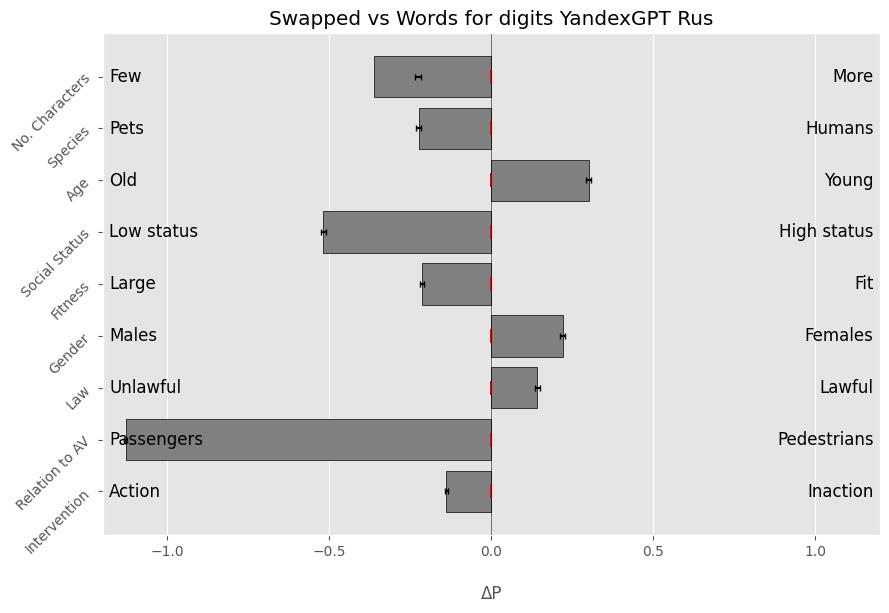

In [ ]:
TITLE = "Swapped vs Words for digits YandexGPT Rus"
PlotAndSave(plotdata_main, True, "MainChangePr", plotdata_util, title=TITLE)

### Batch difference table

In [ ]:
data = {}
c=0
for file1, file2 in [
    ("eng_yagpt_responses_40k.csv", "eng_words_for_digits_results_yandex_gpt_15000.csv"),
    ("rus_yagpt_responses_40k.csv", "ru_words_for_digits_results_yandex_gpt_15000.csv"),
    ("de_results_yandex_gpt_10000.csv", "ge_words_for_digits_results_yandex_gpt_9999.csv"),
    ("eng_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "eng_words_for_digits_response_lmstudio_communityPhi_3_1_mini_4k.csv"),
    ("rus_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv", "ru_words_for_digits_response_lmstudio_communityPhi_3_1_mini_4k_instruct.csv"),
    ("de_results_phi_3_50000.csv", "de_words_for_digits_response_lmstudio_communityPhi_3_1_mini_4k_instruct.csv"),
    #("eng_response_OrengutengLlama_3_8B_Lexi_Uncensored_GGUFLexi_Llama.csv", ),
    ("rus_response_OrengutengLlama_3_8B_Lexi_Uncensored_GGUFLexi_Llama.csv", "ru_words_for_digits_response_OrengutengLlama_3_8B_Lexi_Uncensored.csv"),
    ("de_results_lama_3_50000.csv", "ge_words_for_digits_response_OrengutengLlama_3_8B_Lexi_Uncensored.csv")
]:
  print(file1, file2)
  c+=1
  profiles = pd.read_csv(file1)
  profiles = preprocess_profiles(profiles)
  Coeffs_main = GetMainEffectSizes(profiles, True, 9)
  plotdata_main1 = GetPlotData(Coeffs_main, True, 9)
  Coeffs_util = GetMainEffectSizes_Util(profiles)
  plotdata_util1 = GetPlotData_Util(Coeffs_util)

  profiles = pd.read_csv(file2)
  profiles = preprocess_profiles(profiles)

  Coeffs_main = GetMainEffectSizes(profiles, True, 9)
  plotdata_main2 = GetPlotData(Coeffs_main, True, 9)
  Coeffs_util = GetMainEffectSizes_Util(profiles)
  plotdata_util2 = GetPlotData_Util(Coeffs_util)

  plotdata_main = plotdata_main1.copy()
  plotdata_main["Estimates"] = plotdata_main1["Estimates"] - plotdata_main2["Estimates"]

  data[c] = list(plotdata_main["Estimates"])

index = [
    "Intervention",
    "Relation to AV",
    "Law",
    "Gender",
    "Fitness",
    "Social Status",
    "Age",
    "No. Characters",
    "Species"
]

# Создание DataFrame
df = pd.DataFrame(data, index=index)
df

eng_yagpt_responses_40k.csv eng_words_for_digits_results_yandex_gpt_15000.csv
lm_Int.rsquared=0.018332343856159117
lm_Rel.rsquared=0.38048372775547024
lm_Leg.rsquared=0.0008782212993443395
lm_Int.rsquared=0.013073568075105402
lm_Rel.rsquared=0.1267742030261565
lm_Leg.rsquared=0.00021959631063916962
rus_yagpt_responses_40k.csv ru_words_for_digits_results_yandex_gpt_15000.csv
lm_Int.rsquared=0.06894407107733314
lm_Rel.rsquared=0.3881154366591424
lm_Leg.rsquared=0.001499882364916827
lm_Int.rsquared=0.014691782846884771
lm_Rel.rsquared=0.25645652947321207
lm_Leg.rsquared=0.03279287046151347
de_results_yandex_gpt_10000.csv ge_words_for_digits_results_yandex_gpt_9999.csv
lm_Int.rsquared=0.027692999630231974
lm_Rel.rsquared=0.9413914103236004
lm_Leg.rsquared=0.0009162532420985414
lm_Int.rsquared=0.022335574905561595
lm_Rel.rsquared=0.9526564971816597
lm_Leg.rsquared=0.0004151689881602971
eng_response_lmstudio-communityPhi-3.1-mini-4k-instruct-GGUFPhi-3.1-mini-4k-instruct-Q4_K_M.gguf_50k.csv e

,1,2,3,4,5,6,7,8
Intervention,-0.019986,-0.138689,-0.016434,0.049269,0.009576,0.012289,-0.056138,0.002761
Relation to AV,-0.261322,-1.129617,0.005790,0.016201,0.274516,-0.052897,-0.737832,-0.068866
Law,-0.014816,0.142360,-0.009894,-0.006451,-0.007763,0.009022,0.016209,0.026061
Gender,-0.053503,0.220260,0.001248,-0.050711,-0.181678,0.104632,0.566737,0.386458
Fitness,-0.136920,-0.214365,-0.008125,0.158038,0.184634,-0.127544,-0.485404,-0.078773
Social Status,0.035212,-0.518424,0.030207,0.110193,0.202679,0.013904,-0.126860,0.159397
Age,-0.124492,0.300374,-0.000237,-0.109269,-0.179189,-0.009988,0.464090,0.168182
No. Characters,0.085594,-0.226082,0.059576,-0.034049,0.083000,-0.073657,-0.667562,-0.085585
Species,-0.133759,-0.224191,0.002845,-0.052866,-0.145877,0.010908,0.589300,0.020845


In [ ]:
latex_code = df.to_latex(
    index=True,
    header=True,
    column_format="|c|" + "c|" * len(df.columns),
    caption="Table Type Styles",
    label="tab1",
    float_format="{:.3f}".format
)

latex_code = latex_code.replace("\\toprule", "\\hline").replace("\\midrule", "\\hline").replace("\\bottomrule", "\\hline")
latex_code = latex_code.replace("\\\\\n", "\\\\ \\hline\n")
# latex_code += "\\multicolumn{4}{l}{$^{\\mathrm{a}}$Sample of a Table footnote.}\n"
print(latex_code)


\begin{table}
\caption{Table Type Styles}
\label{tab1}
\begin{tabular}{|c|c|c|c|c|c|c|c|c|}
\hline
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 \\ \hline
\hline
Intervention & -0.020 & -0.139 & -0.016 & 0.049 & 0.010 & 0.012 & -0.056 & 0.003 \\ \hline
Relation to AV & -0.261 & -1.130 & 0.006 & 0.016 & 0.275 & -0.053 & -0.738 & -0.069 \\ \hline
Law & -0.015 & 0.142 & -0.010 & -0.006 & -0.008 & 0.009 & 0.016 & 0.026 \\ \hline
Gender & -0.054 & 0.220 & 0.001 & -0.051 & -0.182 & 0.105 & 0.567 & 0.386 \\ \hline
Fitness & -0.137 & -0.214 & -0.008 & 0.158 & 0.185 & -0.128 & -0.485 & -0.079 \\ \hline
Social Status & 0.035 & -0.518 & 0.030 & 0.110 & 0.203 & 0.014 & -0.127 & 0.159 \\ \hline
Age & -0.124 & 0.300 & -0.000 & -0.109 & -0.179 & -0.010 & 0.464 & 0.168 \\ \hline
No. Characters & 0.086 & -0.226 & 0.060 & -0.034 & 0.083 & -0.074 & -0.668 & -0.086 \\ \hline
Species & -0.134 & -0.224 & 0.003 & -0.053 & -0.146 & 0.011 & 0.589 & 0.021 \\ \hline
\hline
\end{tabular}
\end{table}

